In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import sys

In [2]:
def load_data(filepath):
    """    
    Parameters:
    filepath (cvs): training data.

    Returns:
    x (np.array) : inputs, attributes.
    y (np.array) : outputs.

    """
    X, y = [], []
    with open(filepath, 'r') as file:
        for line in file:
            x, y_ = line.strip().split(',')
            X.append(float(x))
            y.append(float(y_))
    return np.array(X), np.array(y)


def load_sol_data(filepath):
    """    
    Parameters:
    filepath (cvs): solution data.

    Returns:
    m (int) : polynomial degree.
    w (np.array) : weights.

    """
    with open(filepath, 'r') as file:
        m = int(file.readline().strip())
        w = []
        for line in file:
            w_ = float(line.strip())
            w.append(w_)
    return m, np.array(w)



def create_phi(x, degree):
    """
    This function creates a matrix of x values raised to powers.
    :param x: numpy array of input data
    :param degree: degree of the polynomial
    :return: matrix of x values raised to powers
    """
    matrix = np.zeros((len(x), degree + 1))
    for i in range(len(x)):
        for j in range(degree + 1):
            matrix[i][j] = x[i] ** j
    return matrix


def regularized_linear_regression(phi, t, lambda_):
    """
    Find the best fitting regularized weights for a linear model using equation 3.28 from PRML.

    Parameters:
    X : Training data input. (trainPath)
    y : Training data output. (modelOutput)
    lambda_ : Regularization parameter.

    Returns:
    w : Best regularized weights.
    """
    i, size = phi.shape
    phi_t = phi.transpose()
    phit_phi = np.matmul(phi_t, phi)
    id = np.identity(size)
    phit_phi += lambda_ * id
    phit_phi_inv = np.linalg.inv(phit_phi)
    w_reg = np.matmul(phit_phi_inv, phi_t)
    w = np.matmul(w_reg, t)
    return w


# def sweep(X, m, lambda_):
#     """
#     Sweep up to max polynomial (m).

#     Parameters:
#     X : Training data input. (trainPath)
#     m : Given polynomial.
#     lambda_ : Regularization parameter.

#     Returns:
#     weight_list : List of best regularized weights per polynomial.
#     """
#     weight_list = []
#     for i in range(m+1):
#         phi_m = create_phi(X, i)
#         weight = regularized_linear_regression(phi_m, t, 0)
#         weight_list.append(weight)
#     return weight_list


def prediction(X, phi, w):
    """
    Compute prediction for polynomial regression.

    Parameters:
    X (np.array) : Training data input.
    phi (matrix) : Matrix of x values raised to powers.
    w (np.array) : Best regularized weights.

    Returns:
    y(X, phi, w) : prediction.
    """

    return np.dot(phi, w)


def small_phi(phi, r):
    return phi[r]


def errorfunction(y, t):
    error = 0.0
    for i in range(len(y)):
        error += (y[i]-t[i])**2

    return 1/2*error

def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]
    
    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]
    
    return x_train, t_train, x_test, t_test

def rms(error, N):
    return np.sqrt((2*error)/N)


In [12]:
def kfold_cv_k(x, t, M, k):
    """
    K-Fold Cross Validation
    
    Parameters:
    x (np.array): inputs, attributes.
    t (np.array): outputs.
    M (int): polynomial degree.
    k (int): number of folds.
    
    Returns:
    avg_error (float): average root mean squared error.
    """
    data = np.concatenate((x.reshape(-1,1), t.reshape(-1,1)), axis=1)
    # folds = np.array_split(data, k)
    error_list = []
    error_TRAINlist = []

    # print(f"data shape = {data.shape}")
    for i in range(k):
        validation_indices = np.array([j for j in range(len(x)) if j % k == i])
        # print(f"k={k}, validation: {validation_indices.shape}")
        # print(validation_indices)
        validation_fold = data[validation_indices]
        # print(f"valid f = {validation_fold.shape}")
        training_indices = np.array([j for j in range(len(x)) if j % k != i])
        # print(f"k={k}, training: {training_indices.shape}")

        training_folds = data[training_indices]
        x_train, t_train = training_folds[:,0], training_folds[:,1]
        phi_train = create_phi(x_train, M)
        w_train = regularized_linear_regression(phi_train, t_train, 0)
        ######
        Y_train = prediction(x_train, phi_train, w_train)
        error_TRAIN = errorfunction(Y_train, t_train)
        error_TRAINlist.append(error_TRAIN)

        ######
        # print(f"w_train = {w_train}")

        x_test, t_test = validation_fold[:,0], validation_fold[:,1]
        phi_test = create_phi(x_test, M)
        y_test = prediction(x_test, phi_test, w_train)
        
        error = errorfunction(y_test, t_test)
        error_list.append(error)
    avg_error = np.mean(error_list)
    avg_TRAINerror = np.mean(error_TRAINlist)
    
    return avg_error, error_list, avg_TRAINerror, error_TRAINlist


def solve_curve_fitting_k(x, t, M, k):

    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, 0.0)
    y = prediction(x, phi, w)    
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))
    k_fold = kfold_cv_k(x, t, M, k)
    avg_error = k_fold[0]
    errorlist = k_fold[1]
    avg_TRAINerror = k_fold[2]
    error_TRAINlist = k_fold[3]
    # avg_error, errorlist, , error_TRAINlist = kfold_cv_k(x, t, M, k)
    k_rms = np.sqrt(2*avg_error/len(x))
    k_rms_TRAIN = np.sqrt(2*avg_TRAINerror/len(x))

    return w, y, error, rms, avg_error, k_rms, errorlist, k_rms_TRAIN,error_TRAINlist
    # return rms

def plot_tt_k(x, t, m, ratio, k):
    x_train, t_train, x_test, t_test = split_data(x, t, ratio)
    M = np.arange(0, m)
    train_rms = []
    test_rms = []
    for i in M:
        rms = solve_curve_fitting_k(x, t, i, k)
        train_rms.append(rms[7])
        test_rms.append(rms[5])
        
    plt.plot(M, train_rms, '-o', label='Train RMS')
    plt.plot(M, test_rms, '-o', label='Test RMS')
    plt.xlabel('M (degree)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()
    return  train_rms, test_rms

In [13]:
input = load_data("sampleData/X")
X, t = input
M =40
k = 5
ratio = 8/10
fit = solve_curve_fitting_k(X, t, M,k)
w = fit[0]
y = fit[1]
error = fit[2]
rms = fit[3]
avg_error = fit[4]
k_rms = fit[5]
errorlist = fit[6]
error_TRAINlist = fit[8]

In [14]:
errorlist

[1944.515185579557,
 1.601881727818094,
 0.7400018070396216,
 0.15051503831193264,
 0.14519529283350247]

In [15]:
error_TRAINlist

[7783.527462582753,
 6.055829676728428,
 3.2107483450389696,
 0.6554061945882376,
 0.1555234396280391]

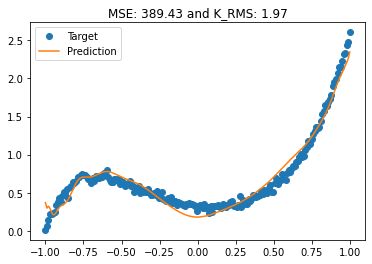

Coefficients: [ 1.79188650e-01  2.53136744e-02  4.93663038e+00 -5.95244286e+00
 -5.13684197e+01  8.57138038e+01  6.15143865e+02 -9.37553821e+02
 -4.61203085e+03  7.72513694e+03  1.94474924e+04 -3.86808659e+04
 -4.21733209e+04  1.09270550e+05  2.99813029e+04 -1.53234591e+05
  4.23292109e+04  3.75218138e+04 -6.87243412e+04  1.51182561e+05
 -1.08851312e+04 -1.19166140e+05  2.00154966e+04 -2.08040720e+04
  4.21579662e+04 -5.74460211e+04  1.09840021e+04  8.14168525e+04
  1.11773685e+04  1.25396479e+05 -1.43056968e+05 -1.07484321e+05
  5.53355265e+04 -9.69513070e+04  1.54359047e+04  7.33080224e+04
  1.63546997e+05  3.28028159e+04 -2.10810312e+05 -2.39981567e+04
  6.92833052e+04]
Mean Squared Error: 389.43055588911204
Root-Mean-Squared: 1.973399492979341


In [16]:
plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('MSE: {:.2f}'.format(avg_error) + ' and K_RMS: {:.2f}'.format(k_rms))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', avg_error)
print('Root-Mean-Squared:', k_rms)

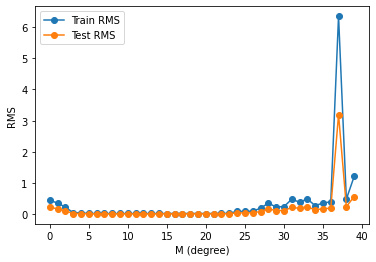

In [17]:
train_rms, test_rms = plot_tt_k(X, t, M, ratio,k)


In [9]:
train_rms

[0.22445783912747533,
 0.18198153484551136,
 0.11671871388307742,
 0.02697275484358084,
 0.025414607867196362,
 0.015696955204961283,
 0.015629876189701186,
 0.015646737315888396,
 0.015661851811126264,
 0.015623252723277905,
 0.01570203084361501,
 0.01571458450462762,
 0.015799804789142603,
 0.015869107385078546,
 0.0160289752403484,
 0.01594450154132068,
 0.016227616434613092,
 0.015992679116784075,
 0.015948415581492636,
 0.01604314095608483,
 0.015819106172790455,
 0.015851853322936614,
 0.016300493558997316,
 0.019400356183901783,
 0.049313247224089383,
 0.048417184423643914,
 0.05269519625849535,
 0.09188929621131542,
 0.1794852760316913,
 0.12141642638104093,
 0.12435843047640602,
 0.2227725667829382,
 0.19582907255206897,
 0.2488306038087626,
 0.14036642114654713,
 0.1870365066023038,
 0.19445466697478112,
 3.1961143312115956,
 0.24702886090923476,
 0.571236634839527]

In [10]:
def when_diverges(train, test):
    for i in range(5, len(train)):
        if train[i] > train[i-1] and train[i] > test[i]:
            return i
        if test[i] > test[i-1] and test[i] > train[i]:
            return i
        # if train[i] > train[i-1] != (test[i] > test[i-1]):
        #     return i
    return None


In [11]:
index = when_diverges(train_rms, test_rms)
index - 1

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'